<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/MixUp_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MixUp augmentation for image classification**

## Introduction


_mixup_ is a *domain-agnostic* data augmentation technique proposed in [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)
by Zhang et al. It's implemented with the following formulas:

![](https://i.ibb.co/DRyHYww/image.png)

(Note that the lambda values are values with the [0, 1] range and are sampled from the
[Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).)

The technique is quite systematically named. We are literally mixing up the features and
their corresponding labels. Implementation-wise it's simple. Neural networks are prone
to [memorizing corrupt labels](https://arxiv.org/abs/1611.03530). mixup relaxes this by
combining different features with one another (same happens for the labels too) so that
a network does not get overconfident about the relationship between the features and
their labels.

mixup is specifically useful when we are not sure about selecting a set of augmentation
transforms for a given dataset, medical imaging datasets, for example. mixup can be
extended to a variety of data modalities such as computer vision, naturallanguage
processing, speech, and so on.

This example requires TensorFlow 2.4 or higher.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.one_hot(y_train, 10)

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
y_test = tf.one_hot(y_test, 10)

4422102/4422102 [==============================] - 2s 0us/step


In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 64
EPOCHS = 10

In [4]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds_one = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE))
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE))
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

## Define the mixup technique function

To perform the mixup routine, we create new virtual datasets using the training data from
the same dataset, and apply a lambda value within the [0, 1] range sampled from a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)
— such that, for example, `new_x = lambda * x1 + (1 - lambda) * x2` (where
`x1` and `x2` are images) and the same equation is applied to the labels as well.

In [5]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = tf.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

**Note** that here , we are combining two images to create a single one. Theoretically,
we can combine as many we want but that comes at an increased computation cost. In
certain cases, it may not help improve the performance as well.

[0.0, 0.0, 0.0, 0.0, 0.1369541883468628, 0.0, 0.0, 0.0, 0.0, 0.8630458116531372]
[1.046899344991914e-09, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 1.688979733849294e-09, 1.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.4180036187171936, 0.0, 0.5819963812828064, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5488394498825073, 0.0, 0.45116057991981506]
[0.0, 0.0, 0.024746716022491455, 0.0, 0.0, 0.0, 0.0, 0.9752532839775085, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.6943102478981018, 0.0, 0.0, 0.3056897521018982, 0.0, 0.0]
[0.0, 0.0, 0.0, 7.611513137817383e-05, 0.0, 0.9999238848686218, 0.0, 0.0, 0.0, 0.0]


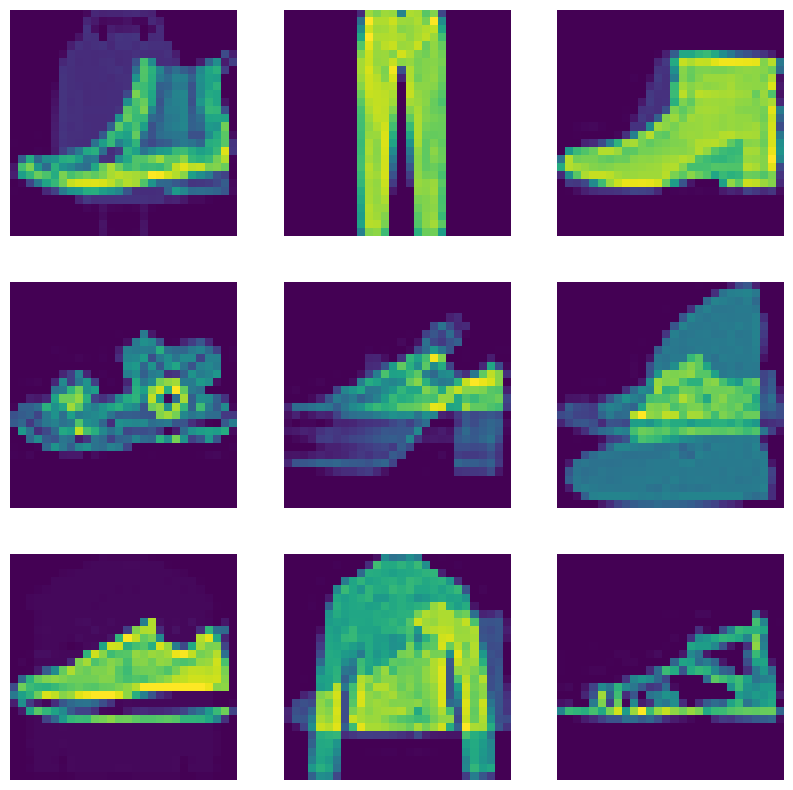

In [6]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2), num_parallel_calls=AUTO)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

In [7]:
def get_training_model():
    model = tf.keras.Sequential(
        [
            layers.Conv2D(16, (5, 5), activation="relu", input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, (5, 5), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Dropout(0.2),
            layers.GlobalAvgPool2D(),
            layers.Dense(128, activation="relu"),
            layers.Dense(10, activation="softmax"),])
    return model

In [8]:
initial_model = get_training_model()
initial_model.save_weights("initial_weights.h5")

## 1. Train the model with the mixed up dataset

In [9]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 19s 5ms/step - loss: 1.1997 - accuracy: 0.6214 - val_loss: 0.6995 - val_accuracy: 0.7555
Epoch 2/10
907/907 [==============================] - 5s 5ms/step - loss: 0.9543 - accuracy: 0.7258 - val_loss: 0.5912 - val_accuracy: 0.7910
Epoch 3/10
907/907 [==============================] - 6s 6ms/step - loss: 0.8613 - accuracy: 0.7646 - val_loss: 0.5017 - val_accuracy: 0.8305
Epoch 4/10
907/907 [==============================] - 4s 5ms/step - loss: 0.8076 - accuracy: 0.7872 - val_loss: 0.4498 - val_accuracy: 0.8495
Epoch 5/10
907/907 [==============================] - 5s 5ms/step - loss: 0.7695 - accuracy: 0.7994 - val_loss: 0.4226 - val_accuracy: 0.8580
Epoch 6/10
907/907 [==============================] - 5s 6ms/step - loss: 0.7496 - accuracy: 0.8068 - val_loss: 0.4099 - val_accuracy: 0.8640
Epoch 7/10
907/907 [==============================] - 5s 5ms/step - loss: 0.7232 - accuracy: 0.8162 - val_loss: 0.3832 - val_accuracy: 0.8680
Epoch

## 2. Train the model *without* the mixed up dataset

In [10]:
model = get_training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Notice that we are NOT using the mixed up dataset here
model.fit(train_ds_one, validation_data=val_ds, epochs=EPOCHS)
_, test_acc = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/10
907/907 [==============================] - 10s 7ms/step - loss: 0.8913 - accuracy: 0.6688 - val_loss: 0.6590 - val_accuracy: 0.7535
Epoch 2/10
907/907 [==============================] - 4s 5ms/step - loss: 0.6397 - accuracy: 0.7568 - val_loss: 0.5775 - val_accuracy: 0.7860
Epoch 3/10
907/907 [==============================] - 5s 5ms/step - loss: 0.5616 - accuracy: 0.7904 - val_loss: 0.4988 - val_accuracy: 0.8185
Epoch 4/10
907/907 [==============================] - 5s 5ms/step - loss: 0.5011 - accuracy: 0.8167 - val_loss: 0.4432 - val_accuracy: 0.8400
Epoch 5/10
907/907 [==============================] - 4s 5ms/step - loss: 0.4603 - accuracy: 0.8329 - val_loss: 0.3967 - val_accuracy: 0.8620
Epoch 6/10
907/907 [==============================] - 5s 5ms/step - loss: 0.4364 - accuracy: 0.8404 - val_loss: 0.3909 - val_accuracy: 0.8585
Epoch 7/10
907/907 [==============================] - 5s 5ms/step - loss: 0.4110 - accuracy: 0.8495 - val_loss: 0.3631 - val_accuracy: 0.8665
Epoch

Readers are encouraged to try out mixup on different datasets from different domains and
experiment with the lambda parameter. You are strongly advised to check out the
[original paper](https://arxiv.org/abs/1710.09412) as well - the authors present several ablation studies on mixup
showing how it can improve generalization, as well as show their results of combining
more than two images to create a single one.



## Notes

* With mixup, you can create synthetic examples — especially when you lack a large
dataset - without incurring high computational costs.
* [Label smoothing](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/) and mixup usually do not work well together because label smoothing
already modifies the hard labels by some factor.
* mixup does not work well when you are using [Supervised Contrastive
Learning](https://arxiv.org/abs/2004.11362) (SCL) since SCL expects the true labels
during its pre-training phase.
* A few other benefits of mixup include (as described in the [paper](https://arxiv.org/abs/1710.09412)) robustness to
adversarial examples and stabilized GAN (Generative Adversarial Networks) training.
* There are a number of data augmentation techniques that extend mixup such as
[CutMix](https://arxiv.org/abs/1905.04899) and [AugMix](https://arxiv.org/abs/1912.02781).